In [1]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
import matplotlib.pyplot as plt
import os


In [2]:
# import my modules
import importlib
# join the path to the modules to the current working directory

import utils, dataset_utils
importlib.reload(utils)
importlib.reload(dataset_utils)
from utils import *
from dataset_utils import *

In [3]:
# make folders plots, data results if they dont exist
for folder in ['plots', 'data', 'results', 'data/lenses']:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
dataset = load_data_set('Statements1000') # load one of Statements1000, BoolQ, Burglar, FreebaseStatements

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cuda


In [6]:
model=None
torch.cuda.empty_cache()

In [8]:
access_token = input("Enter your access token: ")

In [9]:
# load model
# model_name = "mistralai/Mistral-7B-v0.1"
model_name = "meta-llama/Llama-2-7b-chat-hf"
# model_name = "huggyllama/llama-7b"
# load tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, token=access_token).to(device).eval()
tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
tokenizer.padding_side = "left"
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [28]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head):

In [ ]:
# get tuned lenses

file = 'https://huggingface.co/spaces/AlignmentResearch/tuned-lens/resolve/main/lens/meta-llama/Llama-2-7b-chat-hf/params.pt?download=true'

# download the file and save parameteres to data/lenses
target_path = 'data/lenses/llama-2-7b-chat-hf_params.pt'
if not os.path.exists(target_path):
    os.system(f"wget {file} -O {target_path} -q")


In [19]:
raw_lenses = torch.load(target_path)

In [42]:
lenses = []

for i in range(model.config.num_hidden_layers):
    lens = torch.nn.Linear(in_features=model.config.hidden_size, out_features=model.config.hidden_size, bias=True)
    lens.weight = torch.nn.Parameter(raw_lenses[f'{i}.weight'].to(torch.float16))
    lens.bias = torch.nn.Parameter(raw_lenses[f'{i}.bias'].to(torch.float16))
    lens = lens.to(device)
    lenses.append(lens)

In [48]:
identity = torch.nn.Identity(model.config.hidden_size).to(device)

In [51]:
# linear layer that has identity matrix as weight and zeros as bias
lens = torch.nn.Linear(in_features=model.config.hidden_size, out_features=model.config.hidden_size, bias=False)
lens.weight = torch.nn.Parameter(torch.eye(model.config.hidden_size, dtype=torch.float16).to(device))
lens = lens.to(device)
lenses.append(lens)

# pop first layer
_ = lenses.pop(0)

## Generate data

In [12]:
max_new_tokens = 10
batch_size = 64

In [26]:
lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

change_format(dataset, lie_format, truth_format)

In [27]:
get_overlap_truth_lies(model, tokenizer, dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)

Size of dataset Statements1000: 1012


  0%|          | 0/15 [00:00<?, ?it/s]/root/env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
16it [00:11,  1.40it/s]                        
16it [00:00, 1114.21it/s]             


Success rate when generating truths: 75.59%


16it [00:11,  1.37it/s]                        
16it [00:00, 1122.60it/s]             

Success rate when generating lies:   59.98%
Overlap: 41.11%


## Get the hidden states for all generated tokens

In [29]:
torch.cuda.empty_cache()
# get internal activations
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)
token_positions = range(-max_new_tokens-1, 0, 1)
success = dataset['success']
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
dataset['hidden_states_lie'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_lie'], batch_size=batch_size, token_position=token_positions)
dataset['hidden_states_truth'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_truth'], batch_size=batch_size, token_position=token_positions)


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


In [57]:
dataset['hidden_states_lie'].shape

torch.Size([32, 426, 11, 4096])

# Probability of predicted token over layers

In [52]:
# probability of predicted token over layers
num_samples = len(dataset['answer_lie'])
prob_truth, prob_lie = torch.zeros([num_modules, num_samples, len(token_positions)-1]), torch.zeros([num_modules, num_samples, len(token_positions)-1])

for i in tqdm(range(num_modules)):

    for idx, tp in enumerate(token_positions[:-1]):

        unembedded_truth = unembedd_tuned_lens(model, dataset['hidden_states_truth'][i, :, tp, :], lens=lenses[i])
        unembedded_lie = unembedd_tuned_lens(model, dataset['hidden_states_lie'][i, :, tp, :], lens=lenses[i])

        # predicted token is the next token in the sequence
        predicted_truth_token = dataset['output_tokens_truth']['input_ids'][:,tp+1]
        predicted_lie_token = dataset['output_tokens_lie']['input_ids'][:,tp+1]
      
        prob_truth[i, :, idx] = unembedded_truth.softmax(dim=1)[torch.arange(num_samples), predicted_truth_token]
        prob_lie[i, :, idx] = unembedded_lie.softmax(dim=1)[torch.arange(num_samples), predicted_lie_token]

100%|██████████| 32/32 [00:34<00:00,  1.07s/it]


In [45]:
prob_truth.shape

torch.Size([32, 416, 10])

In [53]:
def plot_prob(prob_t, prob_l, token_pos, dataset_name, plot_all_curves=False):
    # plot
    fig, ax = plt.subplots(figsize=(10, 5))

    if plot_all_curves:
        alpha = prob_t.shape[1]/42600.0
        ax.plot(prob_t, color='tab:blue', alpha=alpha)
        ax.plot(prob_l, color='tab:orange', alpha=alpha)
    ax.plot(prob_t.median(axis=1).values, color='tab:blue', label='truth median')
    ax.plot(prob_l.median(axis=1).values, color='tab:orange', label='lie median')
    ax.plot(prob_t.mean(axis=1), color='tab:blue', label='truth mean', linestyle='--')
    ax.plot(prob_l.mean(axis=1), color='tab:orange', label='lie mean', linestyle='--')

    ax.grid()
    ax.set_xlabel("Layer")
    ax.set_ylabel("Probability")
    ax.set_title(f"Probabilities for {dataset_name} (token {token_pos})")
    ax.legend()

    fig.savefig(f"plots/probability_predicted_token_{dataset_name}_token_pos_{token_pos}.png")

In [73]:
prob_truth.shape

torch.Size([32, 426, 10])

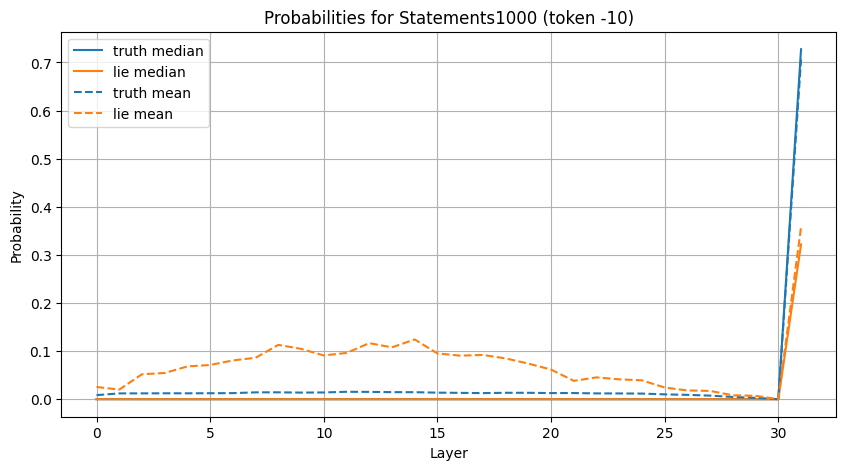

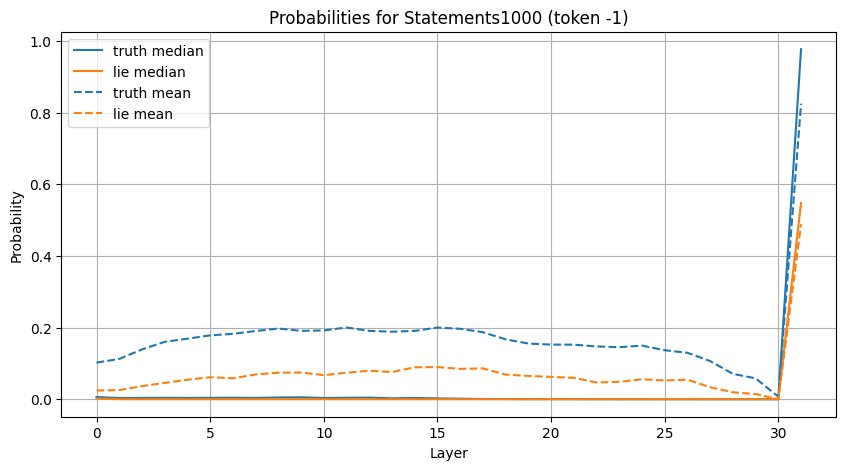

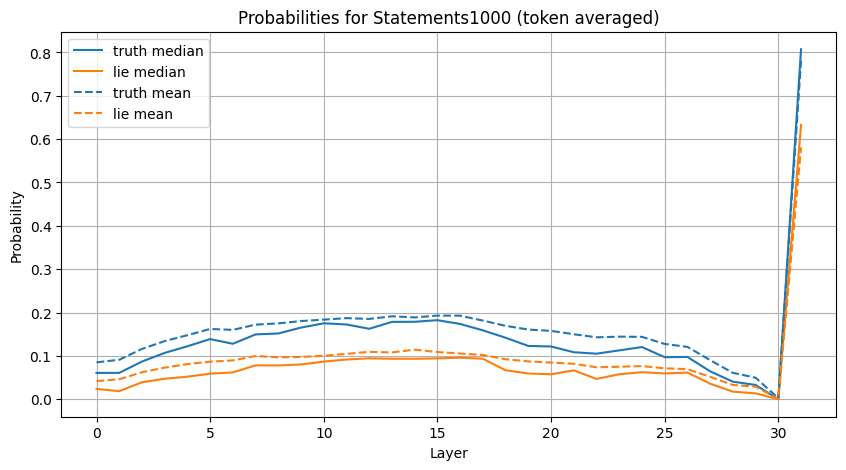

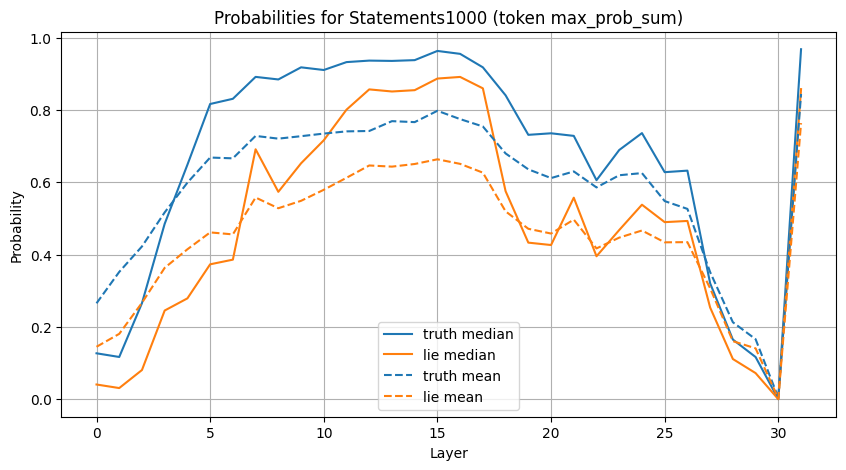

In [54]:
# plot for different token positions

# last token of statement
token_pos = token_positions[1]
plot_prob(prob_truth[:,:,token_pos], prob_lie[:,:,token_pos], token_pos, dataset['dataset_name'])

# last token of answer
token_pos = -1
plot_prob(prob_truth[:,:,token_pos], prob_lie[:,:,token_pos], token_pos, dataset['dataset_name'])

# averaged over all tokens
token_pos = "averaged"
plot_prob(prob_truth.mean(axis=2), prob_lie.mean(axis=2), token_pos, dataset['dataset_name'])

# max_prob
token_pos = "max_prob_sum"

prob_sum_truth = prob_truth.sum(axis=0)
prob_sum_lie = prob_lie.sum(axis=0)

token_pos_truth = prob_sum_truth.argmax(dim=1)
token_pos_lie = prob_sum_lie.argmax(dim=1)

plot_prob(prob_truth[:,range(num_samples),token_pos_truth], prob_lie[:,range(num_samples),token_pos_lie], token_pos, dataset['dataset_name'])
